In [13]:
#download files prenare to download files
import os

DATA_DIRECTORY = 'data'
LIVEJOURNAL_FILENAME = os.path.join(DATA_DIRECTORY, 'livejournal.txt.gz')
LIVEJOURNAL_URL = 'http://snap.stanford.edu/data/twitter_combined.txt.gz'

# Just have these hardcoded, though we don't really need to
NUM_EDGES = 68993773
NUM_NODES = 4847571

In [14]:
# Downloading the file

import urllib.request

assert os.path.exists(DATA_DIRECTORY)

# Get your data. This file is ~250M so it will take a bit
print('DOWNLOADING 250M FILE. WILL SAVE FOR FUTURE USE')
if not os.path.exists(LIVEJOURNAL_FILENAME):
    urllib.request.urlretrieve(LIVEJOURNAL_URL, LIVEJOURNAL_FILENAME)

# Show a little bit of the file
print('\nFILE STATS:')
!ls -lh $LIVEJOURNAL_FILENAME
print('\nSTARTING LINES')
!zcat $LIVEJOURNAL_FILENAME | head -n 30

DOWNLOADING 250M FILE. WILL SAVE FOR FUTURE USE

FILE STATS:
-rwxrwxrwx 1 root root 248M Jun 10 19:59 data/livejournal.txt.gz

STARTING LINES
# Directed graph (each unordered pair of nodes is saved once): soc-LiveJournal1.txt 
# Directed LiveJournal friednship social network
# Nodes: 4847571 Edges: 68993773
# FromNodeId	ToNodeId
0	1
0	2
0	3
0	4
0	5
0	6
0	7
0	8
0	9
0	10
0	11
0	12
0	13
0	14
0	15
0	16
0	17
0	18
0	19
0	20
0	21
0	22
0	23
0	24
0	25
0	26

gzip: stdout: Broken pipe


In [15]:
# Cleaning the data

import numpy as np
import gzip

def row_generator():
    """This will generate all the edges in the graph."""
    with gzip.open(LIVEJOURNAL_FILENAME, 'rt') as f:
        for line in f:
            if line.startswith('#'):
                continue
            else:
                (left_node, right_node) = line.split('\t')
                yield(int(left_node), int(right_node))

def to_undirected(edge_iterable, num_edges, num_nodes, shuffle=True):
    """Takes an iterable of edges and produces the list of edges for the undirected graph.
    
    > to_undirected([[0,1],[1,2],[2,10]], 3, 11)
    array([[ 0,  1],
       [ 1,  0],
       [ 1,  2],
       [ 2,  1],
       [ 2, 10],
       [10,  2]])
    """
    # need int64 to do gross bithacks
    as_array = np.zeros((num_edges, 2), dtype=np.int64)
    for (i, (n_0, n_1)) in enumerate(edge_iterable):
            as_array[i,0] = n_0
            as_array[i,1] = n_1
    # The graph is directed, but we want to make it undirected,
    # which means we will duplicate some rows.

    left_nodes = as_array[:,0]
    right_nodes = as_array[:,1]
    
    if shuffle:
        the_shuffle = np.arange(num_nodes)
        np.random.shuffle(the_shuffle)
        left_nodes = the_shuffle.take(left_nodes)
        right_nodes = the_shuffle.take(right_nodes)

    
    # numpy.unique will not unique whole rows, so this little bit-hacking
    # is a quick way to get unique rows after making a flipped copy of
    # each edge.
    max_bits = int(np.ceil(np.log2(num_nodes + 1)))
    
    encoded_edges_forward = np.left_shift(left_nodes, max_bits) | right_nodes
    
    # Flip the columns and do it again:
    encoded_edges_reverse = np.left_shift(right_nodes, max_bits) | left_nodes

    unique_encoded_edges = np.unique(np.hstack((encoded_edges_forward, encoded_edges_reverse)))
    
    left_node_decoded = np.right_shift(unique_encoded_edges, max_bits)
    
    # Mask out the high order bits
    right_node_decoded = (2 ** (max_bits) - 1) & unique_encoded_edges
    
    undirected_edges = np.vstack((left_node_decoded, right_node_decoded)).T.astype(np.int32)

    # ascontiguousarray so that it's c-contiguous for cython code below
    return np.ascontiguousarray(undirected_edges)


def get_clean_data(shuffle=True):
    if shuffle:
        name = os.path.join(DATA_DIRECTORY, 'LJ-cleaned-shuffled.npy')
    else:
        name = os.path.join(DATA_DIRECTORY, 'LJ-cleaned.npy')

    if os.path.exists(name):
        print('Loading from file {}'.format(name))
        return np.load(name)
    else:
        print('Parsing from zip. Will write to file {}'.format(name), flush=True)
        # Lets get the edges into one big array
        edges = to_undirected(row_generator(), NUM_EDGES, NUM_NODES, shuffle=shuffle)
        print('ORIGINAL DIST: {} MIN: {} MAX: {}'.format(np.abs(edges[:,0] - edges[:,1]).mean(), edges.min(), edges.max()))
        np.save(name, edges)
        return edges

In [16]:
print("Normalizing data (or loaded pre-computed)")
%time edges = get_clean_data(shuffle=True)
%time unshuffled_edges = get_clean_data(shuffle=False)
print('\nEDGES SHAPE: {}'.format(edges.shape))

Normalizing data (or loaded pre-computed)
Loading from file data/LJ-cleaned-shuffled.npy
CPU times: user 121 ms, sys: 599 ms, total: 721 ms
Wall time: 10.1 s
Loading from file data/LJ-cleaned.npy
CPU times: user 53.3 ms, sys: 444 ms, total: 497 ms
Wall time: 9.07 s

EDGES SHAPE: (86220856, 2)


In [17]:
def score(assignment, edges):
    """Compute the score given an assignment of vertices.
    
    N nodes are assigned to clusters 0 to K-1.
    
    assignment: Vector where N[i] is the cluster node i is assigned to.
    edges: The edges in the graph, assumed to have one in each direction
    
    Returns: (total wasted bin space, ratio of edges cut)
    """
    balance = np.bincount(assignment) / len(assignment)
    waste = (np.max(balance) - balance).sum()
    
    left_edge_assignment = assignment.take(edges[:,0])
    right_edge_assignment = assignment.take(edges[:,1])
    mismatch = (left_edge_assignment != right_edge_assignment).sum()
    cut_ratio = mismatch / len(edges)
    return (waste, cut_ratio)

In [18]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [19]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [20]:
%%cython
import numpy as np
cimport cython

cdef int UNMAPPED = -1

def linear_deterministic_greedy(int[:,::] edges,
                                int num_nodes,
                                int num_partitions,
                                int[::] partition):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    edges: An [:,2] array of edges.
    num_nodes: The number of nodes in the graph.
    num_partitions: How many partitions we are breaking the graph into.
    partition: The partition from a previous run. Used for restreaming.

    Returns: A new partition.
    """
    # The output partition

    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)

    cdef int[::] partition_sizes = np.zeros(num_partitions, dtype=np.int32)
         
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    # Fine to be a little off, to stay integers
    cdef int partition_capacity = int(num_nodes / num_partitions)
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef int max_val = 0
    cdef int val = 0
    cdef int len_edges = len(edges)
    
    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # We have found a new node so assign last_left to a partition
                
            max_arg = 0
            max_val = (partition_votes[0]) * (
                       partition_capacity - partition_sizes[0])

            for arg in range(1, num_partitions):
                val = (partition_votes[arg]) * (
                       partition_capacity - partition_sizes[arg])
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_val == 0:
                max_arg = arg
                # No neighbors (or multiple maxed out) so "randomly" select
                # the smallest partition
                for arg in range(i % num_partitions, num_partitions):
                    if partition_sizes[arg] < partition_capacity:
                        max_arg = arg
                        max_val = 1
                        break
                if max_val == 0:
                    for arg in range(0, i % num_partitions):
                        if partition_sizes[arg] < partition_capacity:
                            max_arg = arg
                            break


            partition_sizes[max_arg] += 1
            partition[last_left] = max_arg
            partition_votes[:] = 0
            last_left = left

        if partition[right] != UNMAPPED:
            partition_votes[partition[right]] += 1


    # Clean up the last assignment
    max_arg = 0
    max_val = 0
    for arg in range(0, num_partitions):
        if partition_sizes[arg] < partition_capacity:
            val = (partition_votes[arg]) * int(1 - partition_sizes[arg] / partition_capacity)
            if val > max_val:
                max_arg = arg
                max_val = val
    partition[left] = max_arg

    return np.asarray(partition)

In [21]:
def draw_figures(waste_values, edge_score_values, num_partitions):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    (waste_axes, score_axes) = axes
    waste_axes.plot(waste_values, 'r')
    waste_axes.set_xlabel('Round')
    waste_axes.set_ylabel('Number of wasted bins')
    waste_axes.set_ylim(bottom=0)
    waste_axes.set_title('Wasted Bins: {} partitions'.format(num_partitions))
    
    score_axes.plot(edge_score_values, 'r')
    score_axes.set_xlabel('Round')
    score_axes.set_ylabel('Ratio of edges crossing partitions')
    score_axes.set_ylim(bottom=0)
    score_axes.set_title('Score: {} partitions'.format(num_partitions))
    
    fig.tight_layout()

In [22]:
def run_restreaming_greedy(edges, num_nodes, num_partitions=10, num_iterations=10):
    print('\n{} PARTITIONS'.format(num_partitions))
    assignments = None
    print('ROUND\tWASTE\tSCORE')
    waste_values = []
    edge_score_values = []
    flipped_edges = numpy.flipud(edges).copy()
    for i in range(num_iterations):
        assignments = linear_deterministic_greedy(edges, NUM_NODES, num_partitions, assignments)
        (waste, edge_score) = score(assignments, edges)
        waste_values.append(waste)
        edge_score_values.append(edge_score)
        print('{}\t{:0.3f}\t{:0.3f}'.format(i, waste, edge_score))
    draw_figures(waste_values, edge_score_values, num_partitions)


4 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.329
1	0.000	0.224
2	0.000	0.207
3	0.000	0.196
4	0.000	0.191
5	0.000	0.187
6	0.000	0.185
7	0.000	0.183
8	0.000	0.182
9	0.000	0.180
10	0.000	0.179
11	0.000	0.178
12	0.000	0.177
13	0.000	0.177
14	0.000	0.176
CPU times: user 2min 59s, sys: 1min 1s, total: 4min 1s
Wall time: 4min


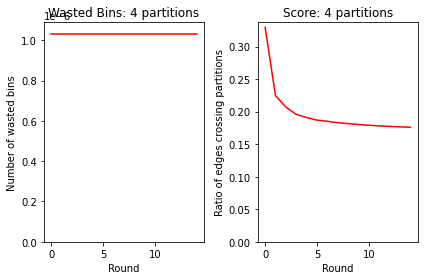

In [23]:
# Use the greedy method to break into 4 partitions
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=4, num_iterations=15)